# 데이터셋 내려받기

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

### Train Data : 80%
### Validation Data : 10%
### Test Data : 10%

---

# 데이터 전처리

In [2]:
IMG_SIZE = 224  # VGG16 기본 입력 크기

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

# 32개의 배치 크기로 데이터 배치처리
train_batches = raw_train.shuffle(1000).map(format_example).batch(32)
validation_batches = raw_validation.map(format_example).batch(32)
test_batches = raw_test.map(format_example).batch(32)

# 모델 설계

In [3]:
base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                         include_top=False,
                                         weights='imagenet')

# VGG 레이어 고정
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

### include_top = False를 통해 완전 연결 레이어를 포함하지 않음

### GlobalAveragePooling2D를 통해 특성들의 평균 계산 후 낮은 차원으로 압축

### 완전 연결 레이어를 직접 만들어줌(512개의 Unit과 ReLU 함수 사용)

### 5개의 class를 구별하므로 Unit을 5로 지정하고 Softmax함수로 확률 출력

---

# 모델 학습

### 다중 분류 임으로 categorical_crossentropy(이진 분류)가 아닌 sparse_categorical_crossentropy를 사용

### epochs = 10번

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches, 
                    epochs=10, 
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 30s 225ms/step - loss: 0.9496 - accuracy: 0.7834 - val_loss: 0.4780 - val_accuracy: 0.8474
Epoch 2/10
92/92 [==============================] - 13s 136ms/step - loss: 0.2813 - accuracy: 0.9131 - val_loss: 0.3676 - val_accuracy: 0.8774
Epoch 3/10
92/92 [==============================] - 13s 138ms/step - loss: 0.0983 - accuracy: 0.9704 - val_loss: 0.3432 - val_accuracy: 0.8910
Epoch 4/10
92/92 [==============================] - 13s 139ms/step - loss: 0.0532 - accuracy: 0.9888 - val_loss: 0.3226 - val_accuracy: 0.8937
Epoch 5/10
92/92 [==============================] - 13s 140ms/step - loss: 0.0271 - accuracy: 0.9956 - val_loss: 0.3677 - val_accuracy: 0.8774
Epoch 6/10
92/92 [==============================] - 13s 141ms/step - loss: 0.0207 - accuracy: 0.9980 - val_loss: 0.3503 - val_accuracy: 0.8828
Epoch 7/10
92/92 [==============================] - 13s 141ms/step - loss: 0.0147 - accuracy: 0.9983 - val_loss: 0.3543 - val_accuracy: 0.8992

# 모델 성능 평가

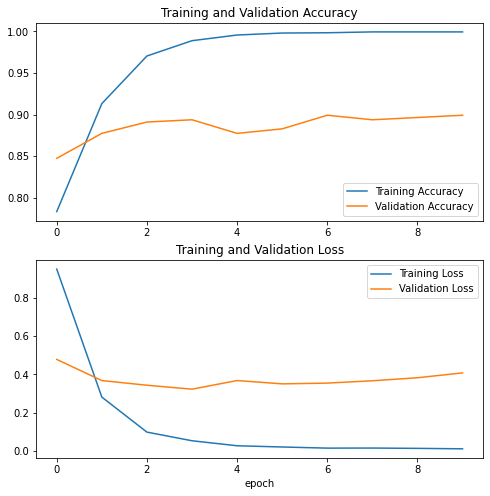

In [5]:
import matplotlib.pyplot as plt

# 그래프로 학습 과정 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test set 성능 평가

In [6]:
loss, accuracy = model.evaluate(test_batches)
print("Test set accuracy:", accuracy)

12/12 [==============================] - 2s 118ms/step - loss: 0.5378 - accuracy: 0.8828
Test set accuracy: 0.8828337788581848


# Test sample에 대한 예측 결과 확인

In [7]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[3.19673514e-13, 2.85326407e-09, 9.99973774e-01, 7.63780927e-10,
        2.61745354e-05],
       [1.00000000e+00, 2.53921313e-15, 1.12399155e-15, 1.28550974e-16,
        1.57000045e-16],
       [9.87335980e-01, 3.27072968e-07, 9.59350073e-05, 1.25675946e-02,
        1.25542783e-07],
       [2.58724555e-07, 9.96873382e-07, 9.36627463e-02, 9.50559742e-10,
        9.06335950e-01],
       [9.99663830e-01, 1.07253065e-04, 1.24641772e-07, 2.22086062e-04,
        6.62824777e-06],
       [9.99991179e-01, 8.87977785e-06, 1.30803687e-10, 1.36400435e-09,
        4.66821648e-09],
       [5.88245224e-04, 8.19761946e-04, 9.98273730e-01, 2.89873133e-04,
        2.83388217e-05],
       [9.52762639e-06, 9.99348462e-01, 7.87924126e-09, 6.41847728e-04,
        1.12030676e-07],
       [2.34441222e-09, 4.69993544e-14, 4.65654147e-11, 1.00000000e+00,
        1.75183725e-15],
       [1.00000000e+00, 2.34180284e-16, 4.41556559e-19, 7.52599428e-17,
        1.14757653e-17],
       [9.99996424e-01, 8.9977

### prediction 값을 실제 추론한 라벨 (0~4 class)로 변환

In [8]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 4, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 1, 2, 4, 0, 0, 4])

### real과 pred를 통해 예측값들을 시각화

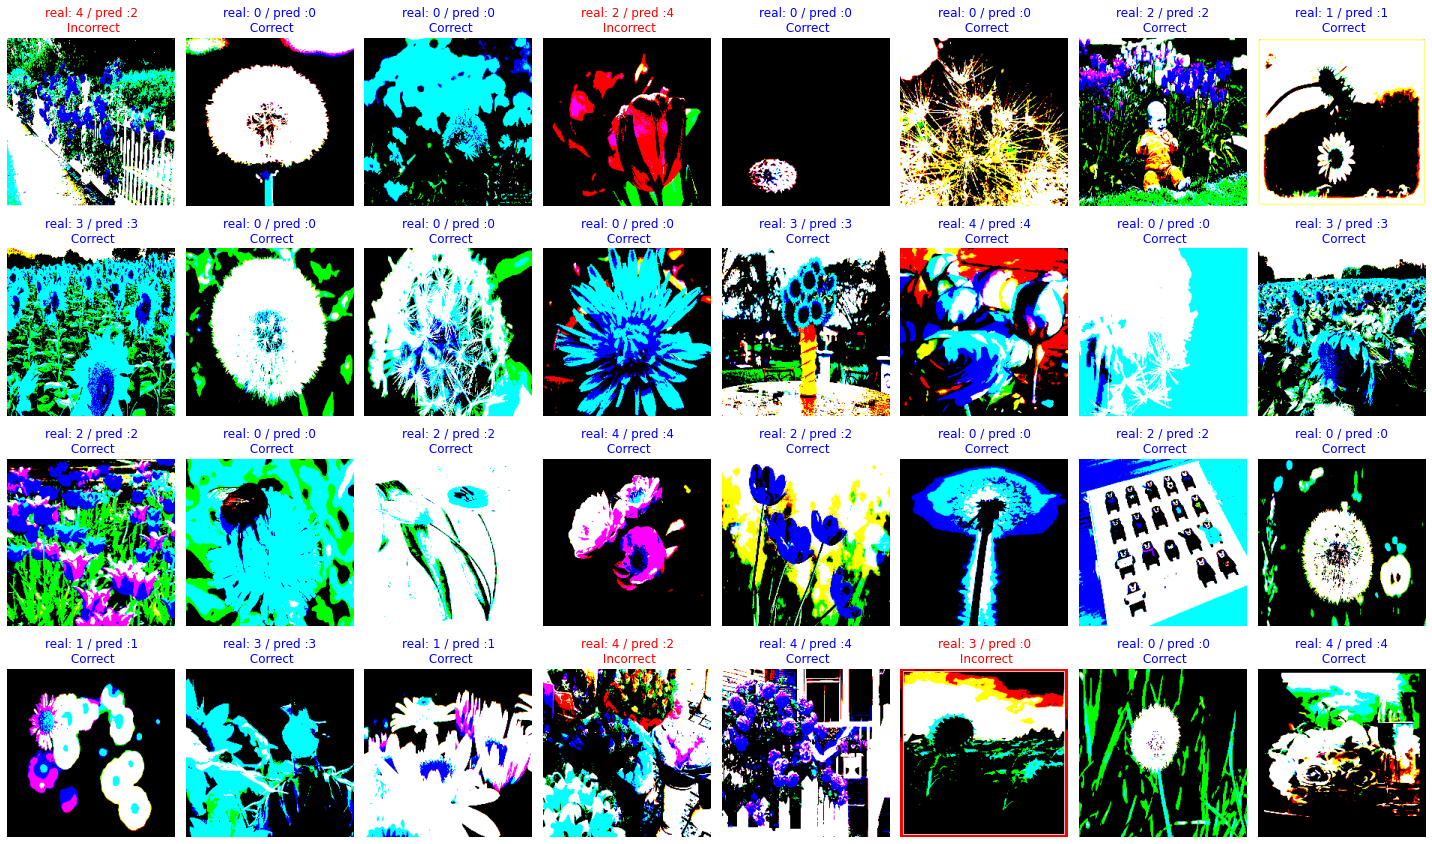

In [9]:
predictions = model.predict(images)
predicted_labels = tf.argmax(predictions, axis=-1)

plt.figure(figsize=(20, 12))

for idx, (image, true_label, predicted_label) in enumerate(zip(images, labels, predicted_labels)):
    plt.subplot(4, 8, idx+1)
    
    # 이미지를 [0, 1] 범위로 조정
    image = (image + 1) / 2
    image = tf.clip_by_value(image, 0, 1)
    
    plt.imshow(image.numpy())
    
    correct = true_label == predicted_label
    title = f'real: {true_label.numpy()} / pred :{predicted_label.numpy()}\n {"Correct" if correct else "Incorrect"}'
    
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')
plt.tight_layout()
plt.show()

### 32개의 대한 정확도

In [18]:
predictions_max = np.argmax(predictions, axis=1) 

count = 0
for label, prediction in zip(labels.numpy(), predictions_max):
    if label == prediction:
        count += 1

# 맞힌 이미지수 / 전체 이미지 수 * 100
print(count / 32 * 100)

87.5


### 87.5%의 정확도를 가진 다는 것을 알 수 있다.